In [124]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

from MoDE import MoDE
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
data = loadmat("data/small_stock.mat")["StockData"]
score = loadmat("data/small_stock.mat")["Score"]

In [126]:
#normalize
m = np.mean(data, axis=1)
data = data - m.reshape((-1,1))

s = np.max(data, axis=1) - np.min(data, axis=1)
data = data / s.reshape((-1,1))

In [127]:
data.shape

(436, 128)

In [128]:
# for now using exact distance matrix
from sklearn.metrics import pairwise_distances
dm = pairwise_distances(data, n_jobs=-1)

In [129]:
# temporary: for now limit the decimals
dm = np.round(dm, decimals=5)

In [149]:
mode = MoDE(n_neighbor=20, max_iter=100000, tol=0.0001, verbose=True)

In [150]:
x_2d = mode.fit_transform(data, score.squeeze(), dm, dm)

cm_lb: 
: [[1.         0.62147087 0.94944444 ... 0.3549705  0.90826787 0.75470886]
 [0.62147087 1.         0.54002753 ... 0.45968349 0.5391052  0.39291787]
 [0.94944444 0.54002753 1.         ... 0.32646576 0.949205   0.86110914]
 ...
 [0.3549705  0.45968349 0.32646576 ... 1.         0.38198444 0.0879193 ]
 [0.90826787 0.5391052  0.949205   ... 0.38198444 1.         0.80656752]
 [0.75470886 0.39291787 0.86110914 ... 0.0879193  0.80656752 1.        ]]
c_ub 
: [0.89693791 0.70978798 0.84431211 ... 0.92875446 0.95483885 0.94049491]
r_ub 
: [0.45800156 0.78159915 0.5655162  ... 0.37975777 0.30167938 0.34671249]
0.005747126436781609
Start of Gradient Descent algorithm
0 out of 100000 iterations has passed
10000 out of 100000 iterations has passed
20000 out of 100000 iterations has passed
GD stopped after 26000 iteration
end of GD algorithm


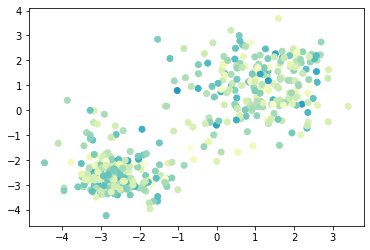

In [151]:
plt.scatter(x_2d[:,0], x_2d[:, 1], c = np.log(score.squeeze()), cmap="YlGnBu")

In [38]:
np.any([False, False])

False